In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import keras
import cv2
from imutils import paths
from matplotlib.image import imread
from tensorflow.keras.models import load_model
from tensorflow import keras

# Disable the PluggableGraphOptimizer
os.environ['TF_ENABLE_PLUGGABLE_GRAPH_OPTIMIZER'] = '0'

import tensorflow as tf

from tensorflow.keras import layers, models, ops
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision

# Set the global policy to mixed_float16
mixed_precision.set_global_policy('mixed_float16')

In [6]:
img_height = 200
img_width = 200
batch_size = 32 # how many images will be processed at once during each step of training

In [2]:
print("TensorFlow version:", tf.__version__)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
if gpus:
    print("GPU Device:", gpus[0])

# Simple computation
a = tf.constant([1.0, 2.0, 3.0])
b = tf.constant([4.0, 5.0, 6.0])
c = a + b
print("Result:", c.numpy())

TensorFlow version: 2.16.2
Num GPUs Available: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result: [5. 7. 9.]


2024-11-14 13:51:57.075813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-14 13:51:57.075857: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-14 13:51:57.075862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-14 13:51:57.075904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 13:51:57.075917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
main_directory = "/Users/nandapop/Documents/Bootcamp/iNaturalist/data/photos"
#main_directory = "/Volumes/Ramirez/inaturalist-open-data/photos"
training_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
#class_names=["antelope","badger","bear","bee","beetle","bison","boar","butterfly","cat","caterpillar", "chimpanzee","cockroach","cow","coyote","crab","crow","deer","dog","dolphin","donkey","dragonfly","duck","eagle"],#subdirectory names
class_names=["bird","cat","dog","fox","hare","lizard","squirrel"],#subdirectory names
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="training",
                        batch_size=batch_size)

validation_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
                        class_names=["bird","cat","dog","fox","hare","lizard","squirrel"],
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="validation",
                        batch_size=batch_size)

Found 34999 files belonging to 7 classes.
Using 31500 files for training.
Found 34999 files belonging to 7 classes.
Using 3499 files for validation.


In [9]:
class_names = training_dataset.class_names
print(class_names)

['bird', 'cat', 'dog', 'fox', 'hare', 'lizard', 'squirrel']


Text(0.5, 1.0, 'Class distribution in training set')

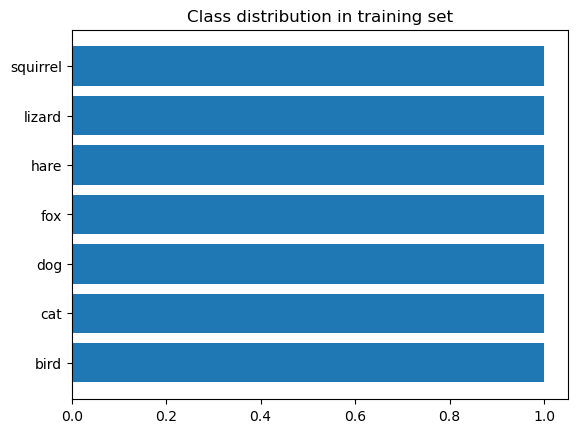

In [10]:
classes, counts = np.unique(training_dataset, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in training set')

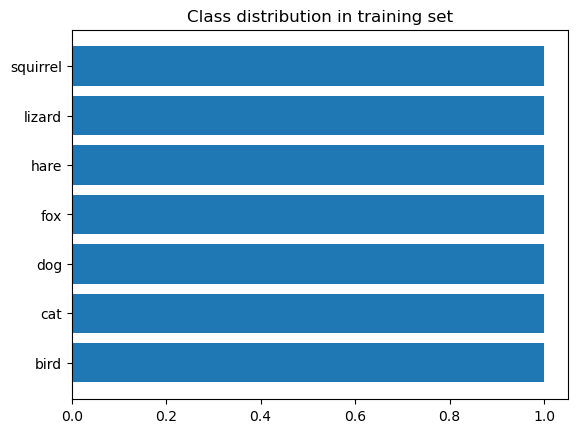

In [11]:
classes, counts = np.unique(training_dataset, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

2024-11-14 14:05:43.298715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


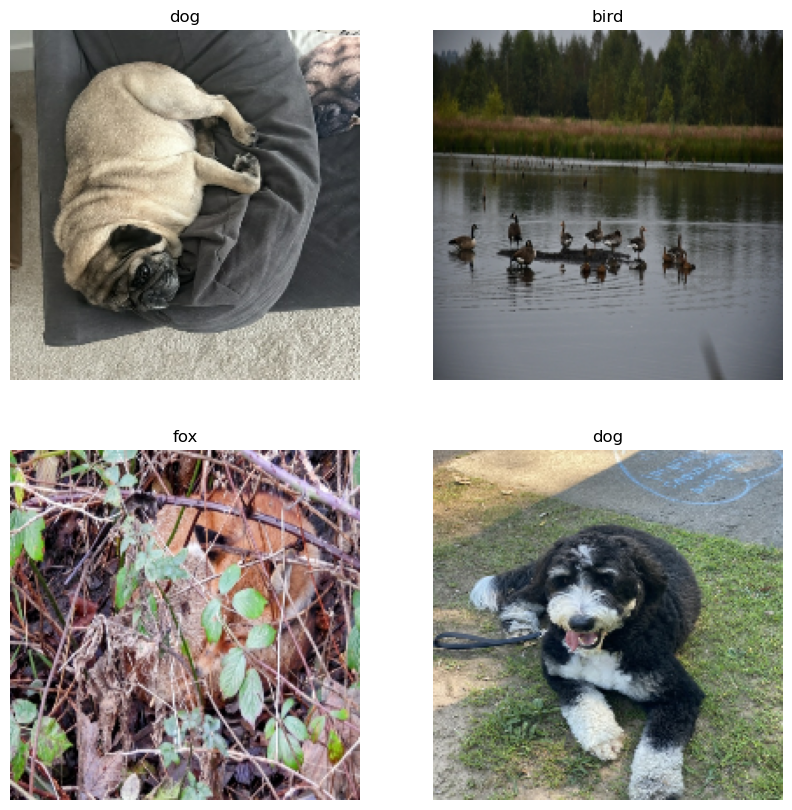

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import os

supported_formats = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')
dataset_dir = "/Volumes/Ramirez/inaturalist-open-data/photos"

unsupported_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if not file.lower().endswith(supported_formats):
            unsupported_files.append(os.path.join(root, file))

if unsupported_files:
    print("Unsupported image formats found:")
    for file in unsupported_files:
        print(file)
        invalid_images = file
else:
    print("All image formats are supported.")


In [ ]:
from pathlib import Path

# Define the path to your dataset directory
dataset_dir = Path('/Volumes/Ramirez/inaturalist-open-data/photos')  # Replace with your actual dataset path

# Define supported image extensions
supported_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

# Recursively gather all image file paths with supported extensions
image_files = [str(file) for ext in supported_extensions for file in dataset_dir.rglob(f'*{ext}')]

print(f"Total images found: {len(image_files)}")


In [ ]:
import tensorflow as tf

valid_images = []
invalid_images = []

for file_path in image_files:
    try:
        # Read the image file
        img = tf.io.read_file(file_path)
        
        # Attempt to decode the image
        # TensorFlow will automatically detect the format
        decoded_img = tf.image.decode_image(img, channels=3)
        
        # Optional: You can add additional checks, like image dimensions
        if decoded_img.shape[0] == 0 or decoded_img.shape[1] == 0:
            raise ValueError("Image has zero size.")
        
        valid_images.append(file_path)
    except Exception as e:
        print(f"Error decoding {file_path}: {e}")
        invalid_images.append(file_path)

print(f"Valid images: {len(valid_images)}")
print(f"Invalid or unsupported images: {len(invalid_images)}")


In [ ]:
import os

for img_path in invalid_images:
    try:
        os.remove(img_path)
        print(f"Removed invalid image: {img_path}")
    except Exception as e:
        print(f"Failed to remove {img_path}: {e}")

print("Cleanup complete.")


In [13]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [14]:
AUTOTUNE=tf.data.AUTOTUNE

#training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Adjusted data pipeline without caching
training_dataset = training_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Train a model

In [16]:
num_classes = len(class_names)

model = Sequential([
  #Convolutional Blocks (4 Times):
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),# pixel values of images from range[0, 255]#pixels 0 to 1
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(), #helps stabilize and accelerate training
  layers.MaxPooling2D(),
  layers.Dropout(0.25), # Prevents overfitting 
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dense(num_classes, activation='softmax')
  layers.Dense(num_classes, activation='softmax', dtype='float32')

])

/opt/miniconda3/envs/tf_new_env/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
'''model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)'''

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,109,959 (19.49 MB)

 Trainable params: 5,108,999 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
#callback
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    mode='min',
    verbose=1
)

In [20]:
#function that train the model
epochs=20

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/20


2024-11-14 14:06:34.488298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-14 14:06:45.649211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 551 of 1000
2024-11-14 14:06:55.089425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.2204 - loss: 2.1392

2024-11-14 14:11:08.258569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 1: val_accuracy improved from -inf to 0.24035, saving model to best_model.keras
985/985 ━━━━━━━━━━━━━━━━━━━━ 279s 257ms/step - accuracy: 0.2204 - loss: 2.1390 - val_accuracy: 0.2404 - val_loss: 2.2445
Epoch 2/20


2024-11-14 14:11:23.087503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 554 of 1000
2024-11-14 14:11:31.860344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3010 - loss: 1.7752

2024-11-14 14:15:40.627972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 2: val_accuracy improved from 0.24035 to 0.25179, saving model to best_model.keras
985/985 ━━━━━━━━━━━━━━━━━━━━ 273s 251ms/step - accuracy: 0.3011 - loss: 1.7751 - val_accuracy: 0.2518 - val_loss: 2.3932
Epoch 3/20


2024-11-14 14:15:56.355928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 579 of 1000
2024-11-14 14:16:04.179967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3299 - loss: 1.7321

2024-11-14 14:20:13.976905: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 3: val_accuracy did not improve from 0.25179
985/985 ━━━━━━━━━━━━━━━━━━━━ 273s 252ms/step - accuracy: 0.3299 - loss: 1.7321 - val_accuracy: 0.2324 - val_loss: 2.7237
Epoch 4/20


2024-11-14 14:20:29.529980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 566 of 1000
2024-11-14 14:20:37.491824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3420 - loss: 1.7070

2024-11-14 14:24:48.176168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 4: val_accuracy did not improve from 0.25179
985/985 ━━━━━━━━━━━━━━━━━━━━ 274s 253ms/step - accuracy: 0.3420 - loss: 1.7070 - val_accuracy: 0.2409 - val_loss: 2.7143
Epoch 5/20


2024-11-14 14:25:03.315806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 567 of 1000
2024-11-14 14:25:11.729321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3538 - loss: 1.6825

2024-11-14 14:29:21.593897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 5: val_accuracy did not improve from 0.25179
985/985 ━━━━━━━━━━━━━━━━━━━━ 274s 252ms/step - accuracy: 0.3538 - loss: 1.6825 - val_accuracy: 0.2315 - val_loss: 2.6690
Epoch 6/20


2024-11-14 14:29:37.232783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 567 of 1000
2024-11-14 14:29:44.672944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3600 - loss: 1.6612

2024-11-14 14:33:52.080958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data



Epoch 6: val_accuracy did not improve from 0.25179
985/985 ━━━━━━━━━━━━━━━━━━━━ 270s 249ms/step - accuracy: 0.3600 - loss: 1.6612 - val_accuracy: 0.2246 - val_loss: 2.7236
Epoch 6: early stopping


In [21]:
model.save('Users/nandapop/Documents/Bootcamp/iNaturalist/data/my_model.keras')
#load model : model = tf.keras.models.load_model('my_model.keras') or 
# model.save('my_model.h5')



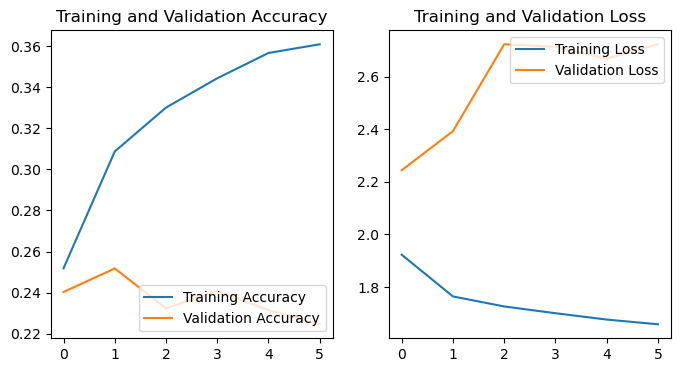

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) 

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/Users/nandapop/Documents/Bootcamp/final_project/data/interim/batch4_epoch_20.png')
plt.show()

In [28]:

img = tf.keras.utils.load_img('/Users/nandapop/Documents/Bootcamp/iNaturalist/data/test/444623699.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions[0])

score = tf.nn.softmax(predictions[0])

print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#["bird","cat","dog","fox","hare","lizard","squirrel"],

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[0.04133599 0.08336766 0.0369288  0.07358626 0.544227   0.04446768
 0.17608656]
tf.Tensor(
[0.12702948 0.13248254 0.12647086 0.13119298 0.21004258 0.12742792
 0.14535366], shape=(7,), dtype=float32)
This image most likely belongs to hare with a 21.00 percent confidence.
